<a href="https://colab.research.google.com/github/yogitaaax22/eeg_website/blob/main/notebooks/google_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Core
import numpy as np
import pandas as pd
import os
import zipfile

# EEG / Signal processing
from scipy.io import loadmat
from scipy.signal import welch

# ML
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

print("All libraries imported successfully")


All libraries imported successfully


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
#Unzip the file
import zipfile

zip_path = '/content/drive/MyDrive/EEG_480_signals.zip'
extract_dir = '/content/eeg_files'

# Extract only once
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("All files extracted to:", extract_dir)


All files extracted to: /content/eeg_files


In [4]:
mat_files = []

for root, dirs, files in os.walk("eeg_data"):
    for file in files:
        if file.endswith(".mat"):
            mat_files.append(os.path.join(root, file))

print("Total EEG files found:", len(mat_files))
print("Example files:", mat_files[:3])


Total EEG files found: 0
Example files: []


In [5]:
import os

DATA_PATH = "eeg_files/raw_data"

mat_files = []
for file in os.listdir(DATA_PATH):
    if file.endswith(".mat"):
        mat_files.append(os.path.join(DATA_PATH, file))

print("Total .mat files found:", len(mat_files))
print("First 5 files:", mat_files[:5])





Total .mat files found: 480
First 5 files: ['eeg_files/raw_data/Arithmetic_sub_6_trial2.mat', 'eeg_files/raw_data/Arithmetic_sub_6_trial3.mat', 'eeg_files/raw_data/Stroop_sub_22_trial3.mat', 'eeg_files/raw_data/Relax_sub_13_trial2.mat', 'eeg_files/raw_data/Arithmetic_sub_27_trial3.mat']


In [6]:
from scipy.io import loadmat

sample = loadmat(mat_files[0])
print(sample.keys())


dict_keys(['__header__', '__version__', '__globals__', 'Data'])


In [7]:
EEG_KEY = 'Data'   # <-- replace this

eeg = sample[EEG_KEY]
print("Original EEG shape:", eeg.shape)


Original EEG shape: (32, 3200)


Single-channel EEG shape: (3200,)


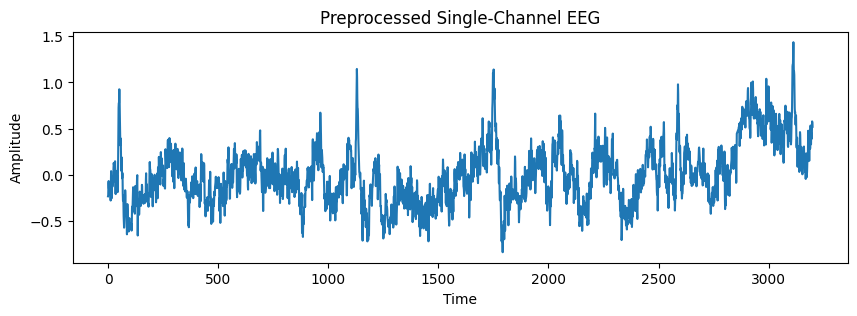

In [8]:
# Ensure shape is (time, channels)
if eeg.shape[0] < eeg.shape[1]:
    eeg = eeg.T

# Normalize
eeg = (eeg - np.mean(eeg)) / np.std(eeg)

# Convert to single channel
eeg_1ch = np.mean(eeg, axis=1)

print("Single-channel EEG shape:", eeg_1ch.shape)

# Plot to verify
import matplotlib.pyplot as plt
plt.figure(figsize=(10,3))
plt.plot(eeg_1ch)
plt.title("Preprocessed Single-Channel EEG")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()


In [9]:
from scipy.signal import welch

def extract_band_power(signal, fs=128):
    freqs, psd = welch(signal, fs=fs)

    bands = {
        'delta': (0.5, 4),
        'theta': (4, 8),
        'alpha': (8, 13),
        'beta': (13, 30)
    }

    features = []
    for band in bands.values():
        idx = (freqs >= band[0]) & (freqs <= band[1])
        features.append(np.mean(psd[idx]))

    return features

features = extract_band_power(eeg_1ch)
print("Extracted band power features:", features)


Extracted band power features: [np.float64(0.011269099072338766), np.float64(0.001397372707282332), np.float64(0.0005881197330480545), np.float64(0.00024257692417681544)]


In [10]:
X = []
y = []

for file_path in mat_files:
    mat = loadmat(file_path)
    eeg = mat['Data']  # (32, 3200)

    if eeg.shape[0] < eeg.shape[1]:
        eeg = eeg.T

    # Normalize per channel
    eeg = (eeg - np.mean(eeg, axis=0)) / np.std(eeg, axis=0)

    band_features = []

    # Extract band power per channel
    for ch in range(eeg.shape[1]):
        ch_signal = eeg[:, ch]
        band_feats = extract_band_power(ch_signal)
        band_features.append(band_feats)

    band_features = np.array(band_features)  # (32, 4)

    # Aggregate channel-wise stats
    mean_feats = band_features.mean(axis=0)
    std_feats  = band_features.std(axis=0)

    final_features = np.concatenate([mean_feats, std_feats])  # (8,)

    X.append(final_features)

    # Binary label (DO NOT CHANGE)
    filename = file_path.lower()
    if 'relax' in filename:
        y.append(0)
    else:
        y.append(1)


In [11]:
X = np.array(X)
y = np.array(y)

print("Feature matrix shape:", X.shape)
print("Labels shape:", y.shape)



Feature matrix shape: (480, 8)
Labels shape: (480,)


In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
# ---- REAL BASELINE: mean of all Relax samples in training set ----
baseline = np.mean(X_train[y_train == 0], axis=0)


print("Training samples:", len(X_train))
print("Testing samples:", len(X_test))


Training samples: 384
Testing samples: 96


In [13]:
model = RandomForestClassifier(
    n_estimators=200,
    random_state=42
)

model.fit(X_train, y_train)

print("Model training completed")


Model training completed


In [14]:
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.7083333333333334

Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.25      0.30        24
           1       0.78      0.86      0.82        72

    accuracy                           0.71        96
   macro avg       0.57      0.56      0.56        96
weighted avg       0.68      0.71      0.69        96



In [15]:
import pickle

# Save trained model
with open("stress_model.pkl", "wb") as f:
    pickle.dump(model, f)

# Save baseline (mean of relax samples in training set)
baseline = X_train[y_train == 0].mean(axis=0)
with open("baseline.pkl", "wb") as f:
    pickle.dump(baseline, f)

print("Model and baseline saved successfully!")


Model and baseline saved successfully!


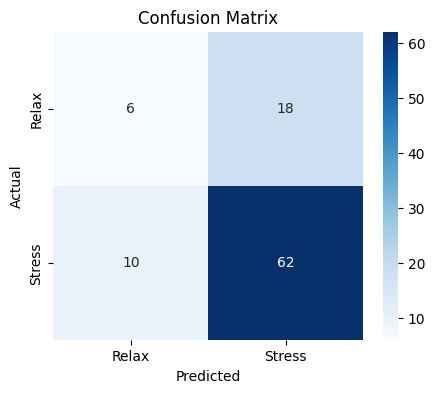

In [16]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Relax', 'Stress'],
            yticklabels=['Relax', 'Stress'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [17]:
# Use X_test (already created)
alpha = X_test[:, 2]   # index 2 = alpha
beta  = X_test[:, 3]   # index 3 = beta

stress_ratio = beta / (alpha + 1e-6)


In [18]:
stress_levels = []

for i in range(len(y_test)):
    if y_pred[i] == 0:
        stress_levels.append(0)   # Relax
    else:
        if stress_ratio[i] < np.percentile(stress_ratio, 33):
            stress_levels.append(1)  # Low Stress
        elif stress_ratio[i] < np.percentile(stress_ratio, 66):
            stress_levels.append(2)  # Moderate Stress
        else:
            stress_levels.append(3)  # High Stress


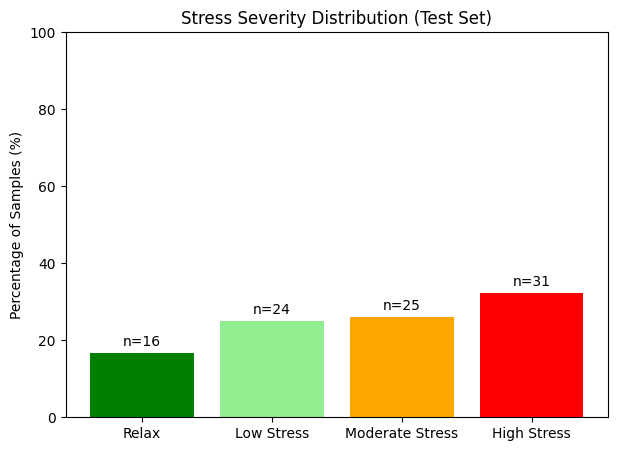

In [19]:
import matplotlib.pyplot as plt
from collections import Counter

counts = Counter(stress_levels)
total = sum(counts.values())

labels = ["Relax", "Low Stress", "Moderate Stress", "High Stress"]
colors = ["green", "lightgreen", "orange", "red"]

percentages = [(counts.get(i, 0) / total) * 100 for i in range(4)]
sample_counts = [counts.get(i, 0) for i in range(4)]

plt.figure(figsize=(7,5))
bars = plt.bar(labels, percentages, color=colors)

plt.ylabel("Percentage of Samples (%)")
plt.title("Stress Severity Distribution (Test Set)")
plt.ylim(0, 100)

# Annotate bars with sample counts
for bar, count in zip(bars, sample_counts):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height + 1,
        f"n={count}",
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.show()


In [20]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')

print("CV Accuracy:", scores.mean(), "±", scores.std())


CV Accuracy: 0.7458333333333333 ± 0.010622957319984966


In [21]:
!ls


baseline.pkl  drive  eeg_files	sample_data  stress_model.pkl


Found 132 files for sub_1
/content/eeg_files/raw_data/Relax_sub_13_trial2.mat
/content/eeg_files/raw_data/Stroop_sub_19_trial3.mat
/content/eeg_files/raw_data/Relax_sub_13_trial3.mat
/content/eeg_files/raw_data/Mirror_image_sub_16_trial2.mat
/content/eeg_files/raw_data/Relax_sub_12_trial1.mat
/content/eeg_files/raw_data/Mirror_image_sub_13_trial1.mat
/content/eeg_files/raw_data/Mirror_image_sub_10_trial1.mat
/content/eeg_files/raw_data/Mirror_image_sub_18_trial3.mat
/content/eeg_files/raw_data/Arithmetic_sub_16_trial3.mat
/content/eeg_files/raw_data/Arithmetic_sub_13_trial2.mat
/content/eeg_files/raw_data/Arithmetic_sub_16_trial1.mat
/content/eeg_files/raw_data/Mirror_image_sub_17_trial3.mat
/content/eeg_files/raw_data/Arithmetic_sub_14_trial3.mat
/content/eeg_files/raw_data/Stroop_sub_10_trial3.mat
/content/eeg_files/raw_data/Stroop_sub_17_trial2.mat
/content/eeg_files/raw_data/Arithmetic_sub_13_trial3.mat
/content/eeg_files/raw_data/Relax_sub_18_trial2.mat
/content/eeg_files/raw_data

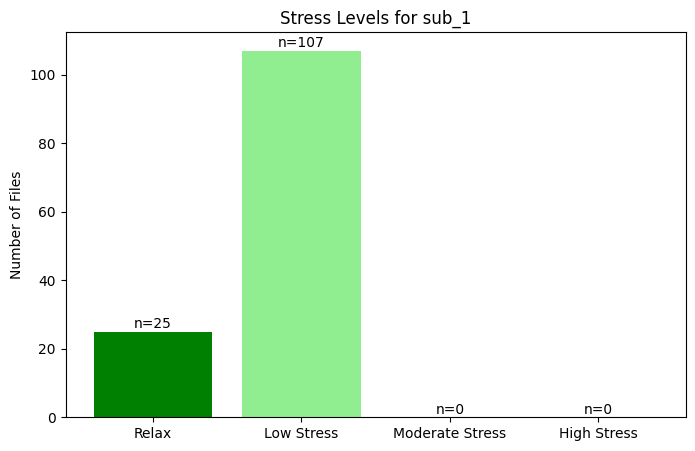

Task: Relax, Stress Level: Relax
Task: Stroop, Stress Level: Low Stress
Task: Relax, Stress Level: Relax
Task: Mirror, Stress Level: Low Stress
Task: Relax, Stress Level: Relax
Task: Mirror, Stress Level: Low Stress
Task: Mirror, Stress Level: Low Stress
Task: Mirror, Stress Level: Low Stress
Task: Arithmetic, Stress Level: Low Stress
Task: Arithmetic, Stress Level: Low Stress
Task: Arithmetic, Stress Level: Low Stress
Task: Mirror, Stress Level: Low Stress
Task: Arithmetic, Stress Level: Low Stress
Task: Stroop, Stress Level: Low Stress
Task: Stroop, Stress Level: Low Stress
Task: Arithmetic, Stress Level: Low Stress
Task: Relax, Stress Level: Low Stress
Task: Relax, Stress Level: Relax
Task: Mirror, Stress Level: Low Stress
Task: Relax, Stress Level: Relax
Task: Stroop, Stress Level: Low Stress
Task: Stroop, Stress Level: Low Stress
Task: Arithmetic, Stress Level: Low Stress
Task: Stroop, Stress Level: Low Stress
Task: Stroop, Stress Level: Low Stress
Task: Arithmetic, Stress Level: 

In [22]:
# -----------------------------
# Imports
# -----------------------------
import os
import numpy as np
from scipy.io import loadmat
from scipy.signal import welch
import pickle
from collections import Counter
import matplotlib.pyplot as plt

# -----------------------------
# Load trained model & baseline
# -----------------------------
with open("stress_model.pkl", "rb") as f:
    model = pickle.load(f)

with open("baseline.pkl", "rb") as f:
    baseline = pickle.load(f)  # 8 features

# -----------------------------
# Feature extraction
# -----------------------------
def extract_band_power(signal, fs=128):
    freqs, psd = welch(signal, fs=fs)
    bands = {'delta': (0.5, 4), 'theta': (4, 8), 'alpha': (8, 13), 'beta': (13, 30)}
    features = []
    for band in bands.values():
        idx = (freqs >= band[0]) & (freqs <= band[1])
        features.append(np.mean(psd[idx]))
    return features  # 4 features per channel

def extract_features(eeg):
    # Ensure shape (time, channels)
    if eeg.shape[0] < eeg.shape[1]:
        eeg = eeg.T

    # Normalize per channel
    eeg = (eeg - np.mean(eeg, axis=0)) / np.std(eeg, axis=0)

    channel_features = []
    for ch in range(eeg.shape[1]):
        band_feats = extract_band_power(eeg[:, ch])
        channel_features.append(band_feats)

    channel_features = np.array(channel_features)  # (channels, 4)
    # Aggregate mean + std across channels
    mean_feats = channel_features.mean(axis=0)
    std_feats  = channel_features.std(axis=0)
    final_features = np.concatenate([mean_feats, std_feats])  # 8 features
    return final_features

# -----------------------------
# Compute multi-level stress
# -----------------------------
def compute_stress_level(features, baseline):
    # Predict binary: 0=Relax, 1=Stress
    pred_binary = model.predict([features])[0]

    if pred_binary == 0:
        return 0  # Relax

    # Deviation from baseline for alpha & beta bands
    alpha_idx = 2
    beta_idx  = 3
    alpha_dev = abs(features[alpha_idx] - baseline[alpha_idx])
    beta_dev  = abs(features[beta_idx]  - baseline[beta_idx])
    stress_index = (alpha_dev + beta_dev) / 2

    # Thresholds
    if stress_index < 0.01:
        return 1  # Low
    elif stress_index < 0.02:
        return 2  # Moderate
    else:
        return 3  # High

# -----------------------------
# Subject file collection
# -----------------------------
subject_id = "sub_1"  # change this to the subject you want
subject_folder = "/content/eeg_files/raw_data"

# Automatically collect all files for that subject
subject_files = [
    os.path.join(subject_folder, f)
    for f in os.listdir(subject_folder)
    if subject_id in f.lower() and f.endswith(".mat")
]

print(f"Found {len(subject_files)} files for {subject_id}")
for f in subject_files:
    print(f)

# -----------------------------
# Process each file
# -----------------------------
stress_levels = []
tasks = []

for file_path in subject_files:
    mat = loadmat(file_path)
    eeg = mat["Data"]

    features = extract_features(eeg)
    level = compute_stress_level(features, baseline)

    # Get task name from filename (Relax, Arithmetic, Mirror, Stroop)
    task_name = os.path.basename(file_path).split("_")[0].capitalize()

    stress_levels.append(level)
    tasks.append(task_name)

# -----------------------------
# Visualize
# -----------------------------
labels = ["Relax", "Low Stress", "Moderate Stress", "High Stress"]
colors = ["green", "lightgreen", "orange", "red"]

counts = Counter(stress_levels)
sample_counts = [counts.get(i, 0) for i in range(4)]

plt.figure(figsize=(8,5))
bars = plt.bar(labels, sample_counts, color=colors)
plt.ylabel("Number of Files")
plt.title(f"Stress Levels for {subject_id}")

for bar, count in zip(bars, sample_counts):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height + 0.1,
        f"n={count}",
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.show()

# Optional: print per-task stress
for t, l in zip(tasks, stress_levels):
    print(f"Task: {t}, Stress Level: {labels[l]}")


In [23]:
from google.colab import files

files.download('stress_model.pkl')
files.download('baseline.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>